In [45]:
import os
import pandas as pd
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import scanpy as sc
from sklearn.metrics import pairwise_distances
import glob
import matplotlib.colors as mcolors
import create_metacells



def lorenz(arr):
    # this is the Lorenz curve function
    arr = np.sort(arr)
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)


def gini(arr):
    # this is the Gini coefficient function
    sorted_arr = arr.copy()
    sorted_arr = np.sort(sorted_arr)
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def double_figure(res,x,y1,y2):
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(res[x],
            res[y1],
            color="red", 
            marker="o")
    # set x-axis label
    ax.set_xlabel(x, fontsize = 14)
    # set y-axis label
    ax.set_ylabel(y1,
                color="red",
                fontsize=14)

    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(res[x], res[y2],color="blue",marker="o")
    ax2.set_ylabel(y2,color="blue",fontsize=14)
    plt.show()


# Data reading

In [3]:
# specify the working directory directory
work_dir = "/path/to/directory/"
# and the path and pattern of readcounts files from hmmcopy utils
path = work_dir + "/readCount_filtered_bam/*.seg"

## Data is loaded at 100kb resolution

In [4]:
# reading counts and regions
files = glob.glob(path)
barcodes = []
# 100000 for 100kb resolution 
step = 100000
counts = []
for i, file_name in enumerate(tqdm(files)):
    cs = []
    try:
        file = pd.read_csv(file_name, sep="\t", header=None)
        barcode = file_name.split("/")[-1].split("_")[-1].split('.')[0]
        barcodes.append(barcode)
        for tup in file.itertuples():
            try:
                c = int(tup[1])
                cs.append(c)
            except ValueError:
                pass
        counts.append(cs)
    except:
        print(file_name)
for i, file_name in enumerate(tqdm(files)):
    chrom, start = ['', '']

    if i == 0:
        regions = []
        print("recording")
        file = pd.read_csv(file_name, sep="\t", header=None)
        for tup in file.itertuples():
            try:
                c = int(tup[1])
                regions.append((chrom, start0))
                start0 = start0+step
            except ValueError:
                chrom, start, _ = [x.split("=")[1]
                                   for x in tup[1].split(" ")[1:-1]]
                start0 = int(start)
                pass

  0%|          | 0/4256 [00:00<?, ?it/s]

100%|██████████| 4256/4256 [00:00<00:00, 45998.26it/s]

recording


In [5]:
# combining the counts into a single dataframe
counts_df_orig = pd.DataFrame(counts)
counts_df_orig.index = barcodes
counts_df_orig.columns = [f"{x[0]}:{x[1]}-{x[1]+step}" for x in regions]
counts_df_orig.head()

,chr1:1-100001,chr1:100001-200001,chr1:200001-300001,chr1:300001-400001,chr1:400001-500001,chr1:500001-600001,chr1:600001-700001,chr1:700001-800001,chr1:800001-900001,chr1:900001-1000001,...,chrY:56300001-56400001,chrY:56400001-56500001,chrY:56500001-56600001,chrY:56600001-56700001,chrY:56700001-56800001,chrY:56800001-56900001,chrY:56900001-57000001,chrY:57000001-57100001,chrY:57100001-57200001,chrY:57200001-57300001
TTGCCCATCTACTTTG-1,0,0,0,0,0,0,2,4,2,12,...,0,0,0,0,0,12,0,0,0,0
GCCAGCATCCTAAAGC-1,0,0,0,0,0,0,0,0,6,2,...,0,0,0,0,0,11,0,0,0,0
GAAATGATCTACCCGT-1,0,0,0,0,0,0,0,0,6,9,...,0,0,0,0,0,9,0,0,0,0
ACAATCGTCACTCCCA-1,0,0,0,0,0,0,2,0,8,12,...,0,0,0,0,0,4,0,0,0,0
GCACGGTGTGATGTGG-1,0,0,0,0,0,0,14,0,2,6,...,0,0,0,0,0,11,0,0,0,0


# Data initial analysis and filtering

## Gini index filtering to decide on the optimal cut-off for low quality cells (sample specific)

In [6]:
gini_matac = counts_df_orig.apply(lambda row: gini(row), axis=1).values

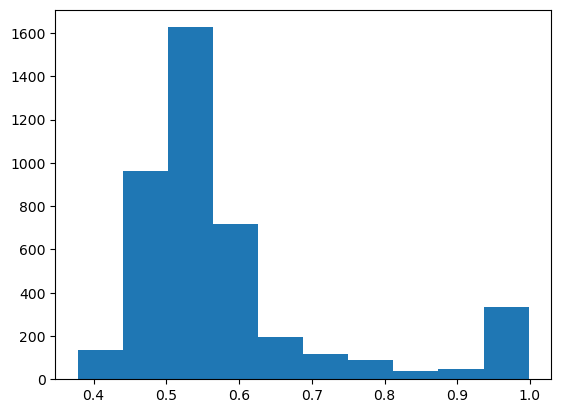

In [7]:
# show the distribution of gini coefficients for each cell and decide on the cut-off
plt.hist(gini_matac)
plt.show()

In [8]:
cutoff = 0.9
counts_df_orig = counts_df_orig[gini_matac < cutoff]

## Counts distribution to verify the average number of reads per 100kb 

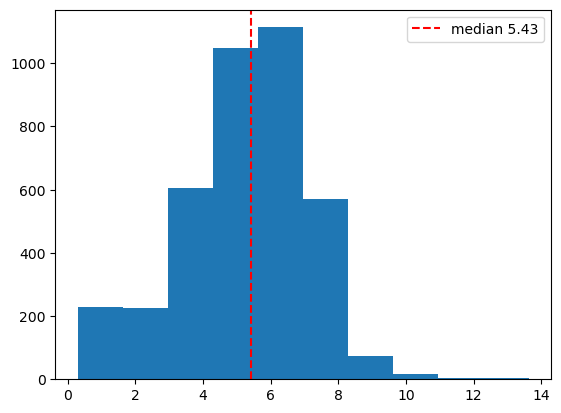

In [9]:

plt.hist(counts_df_orig.mean(axis =1))
m = counts_df_orig.mean(axis =1).median()
plt.axvline(m, label = f"median {m:.2f}", color = "red", ls = "--")
plt.legend()

# Aggregating counts to 1MB
We need this step for metacelling to reduce data sparcity and improve coverage unformity

In [10]:
counts = counts_df_orig.copy().values
new_step = 1000000 #1MB
i0 = 0
chrom = "chr1"
start0 = 1
new_counts = []
counts0 =np.zeros(counts_df_orig.shape[0])
new_regions = []
for i,rec in tqdm(enumerate(regions)):
    if rec[0] == chrom and (rec[1] - start0 < new_step):
        counts0 += counts[:,i]
        region = f"{rec[0]}:{start0}-{start0+new_step}"
    else:
        new_counts.append(counts0)
        new_regions.append(region)
        start0 = rec[1]
        counts0 = counts[:,i]
        chrom = rec[0]
        region = f"{rec[0]}:{start0}-{start0+new_step}"

30894it [00:00, 70715.09it/s]


In [11]:
counts_df = pd.DataFrame(new_counts, index = new_regions, columns = counts_df_orig.index).T

In [12]:
counts_df.head()

,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:47000001-48000001,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001
TTGCCCATCTACTTTG-1,20.0,105.0,54.0,120.0,67.0,79.0,138.0,118.0,137.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
GCCAGCATCCTAAAGC-1,8.0,49.0,78.0,95.0,73.0,112.0,131.0,126.0,104.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
GAAATGATCTACCCGT-1,15.0,52.0,54.0,74.0,44.0,48.0,63.0,49.0,38.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
ACAATCGTCACTCCCA-1,22.0,94.0,131.0,114.0,82.0,114.0,133.0,94.0,101.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
GCACGGTGTGATGTGG-1,22.0,38.0,94.0,139.0,137.0,131.0,70.0,61.0,28.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [20]:
# save intermidiate results to csv files
counts_df.to_csv(work_dir+ "counts_1mb.csv")

# Create andata object for further analysis

## The object creation and QC

In [13]:
adata = sc.AnnData(counts_df)

In [14]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


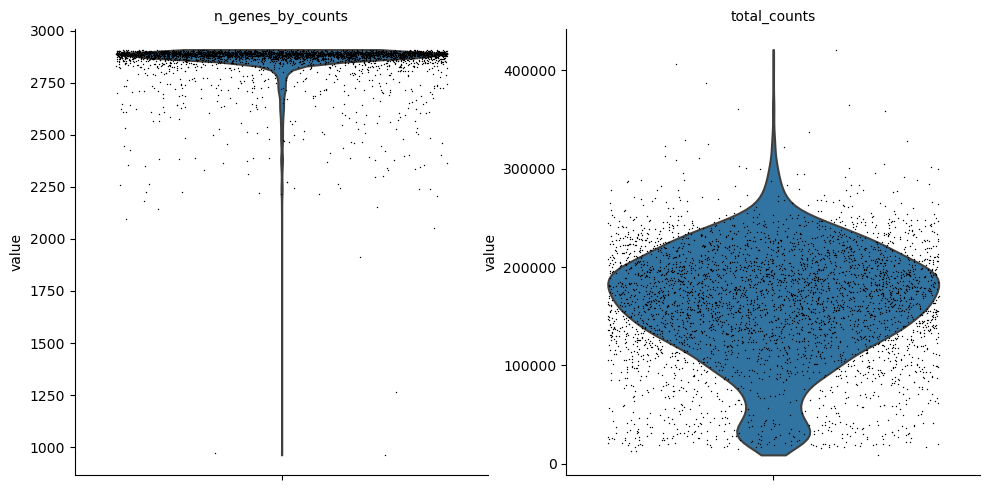

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)
adata = adata[adata.obs.total_counts > 10000, :]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Calculate PCA and UMAP

In [16]:
# Increase the number of num_comp if the variance ratio is around 0.95
# This step might take some time
num_comp = 1000
sc.tl.pca(adata, svd_solver='arpack', n_comps = num_comp)
print(np.cumsum(adata.uns["pca"]['variance_ratio'])[-1])

0.9232214851783456


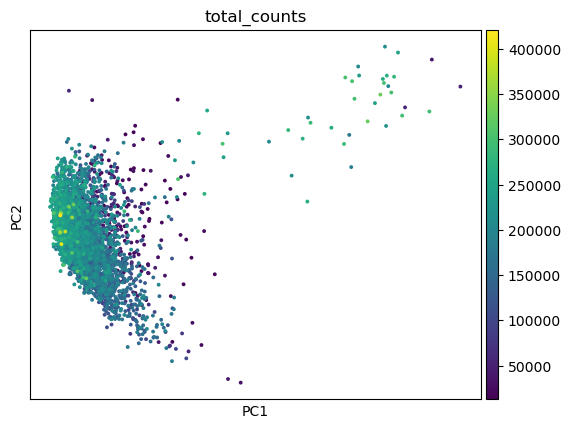

In [17]:
sc.pl.pca(adata,color = "total_counts")


In [18]:
sc.pp.neighbors(adata,n_pcs = num_comp)
# if this step fails with a memory error, try setting n_pcs to a lower value

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# compute UMAP
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) 
sc.tl.umap(adata, init_pos='paga')


# Metacelling

## Create initial metacells

In [22]:
# Those are parameters for initial metacells
# Do not modify them unless you know what you are doing
max_coverage = 1100
min_coverage = 200

In [23]:
#set the resolution such that the maximum coverage is close to max_covergae
# higher resolution =>  lower maximum coverage
sc.tl.leiden(adata, resolution = 108, key_added = "leiden_small")
clust_df = []
clusters = adata.obs.leiden_small.unique()
for meta in clusters:
    dat = adata.obs[adata.obs.leiden_small == meta]
    subset = adata[dat.index]
    clust_df.append([meta,
                     counts_df.loc[dat.index].sum(axis = 0).mean(),
                     subset.shape[0],
                     float(subset.obsm['X_umap'][:,0].mean()),float(subset.obsm['X_umap'][:,1].mean()),
                     # float(subset.obsm['X_pca'][:,0].mean()),float(subset.obsm['X_pca'][:,1].mean()),
                    *subset.obsm["X_pca"].mean(axis = 0)])
clust_df = pd.DataFrame(clust_df, columns = ["cl", "coverage", "n_cells","umap_x","umap_y",*[f"PC_{i}" for i in range(num_comp)]])
print(f"Maximal coverage for initial metacells {clust_df.coverage.max()} (should be close to {max_coverage})")


Maximal coverage for initial metacells 1036.6530151564011 (should be close to 1100)


In [24]:
clust_df["pass_min"] = clust_df.coverage>=min_coverage
clust_df["pass_max"] = clust_df.coverage<=min_coverage
adata.obs["counts_per_1MB"] = adata.obs["total_counts"]/adata.var.shape[0]

In [28]:
clust_df

,cl,coverage,n_cells,umap_x,umap_y,PC_0,PC_1,PC_2,PC_3,PC_4,...,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,pass_min,pass_max
0,43,435.154789,6,10.883160,2.697644,-8.384673,18.023706,-0.162192,3.616431,5.341103,...,0.057762,0.226568,0.237488,0.032000,-0.512541,-0.155243,0.261576,0.188353,True,False
1,96,285.073525,5,8.450649,4.166116,-1.427566,6.875573,-4.241607,-3.253848,-3.612098,...,0.248657,0.057784,-0.213799,-0.090760,-0.268863,0.099168,0.039559,-0.054978,True,False
2,827,87.934215,2,8.254582,7.843760,-8.423372,-2.401423,6.860295,2.353600,-2.750950,...,0.008220,0.082858,-0.317726,0.095669,-0.209279,-0.296195,-0.174332,0.072419,False,True
3,825,113.506933,2,9.606754,6.078070,-2.409463,5.902359,2.826293,1.817286,1.348184,...,0.252531,0.112443,-0.100603,-0.003582,-0.136482,-0.052373,0.164041,-0.164022,False,True
4,295,163.941309,4,4.253043,8.012704,6.416449,-14.029268,2.126328,0.347804,1.944328,...,-0.001063,0.270210,-0.162936,0.146151,-0.249730,-0.333691,-0.181347,-0.175183,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1018,64.539181,1,7.768841,5.329771,-6.378467,1.651139,0.374592,-5.557203,0.495362,...,-0.013773,0.546435,-0.229584,-0.512107,0.086622,-0.301922,-0.629666,0.414640,False,True
1222,1212,36.958723,1,7.307236,7.531071,-6.528047,-4.808792,3.866281,4.157404,2.882963,...,-0.347377,-0.232742,-0.101589,0.710438,0.256527,-0.072960,0.025808,-0.483475,False,True
1223,1177,48.430184,1,5.039428,6.920526,1.157472,-7.910464,-3.200777,-3.747092,6.056699,...,-0.149002,0.562348,0.005838,0.185014,0.678942,0.095260,0.180750,0.004466,False,True
1224,1199,43.223154,1,9.226414,6.766268,-4.265072,-0.094065,12.084394,0.257129,-4.436928,...,0.448871,-0.476543,-0.545717,0.294522,-0.069684,0.170004,0.703408,-0.298628,False,True


In [26]:
palette = sns.color_palette("Purples", as_cmap = True)
custom_colormap = mcolors.LinearSegmentedColormap.from_list(
    "CustomPurple", [(0, palette(0.4)), (0.4, palette(0.8)), (1, palette(0.9))]
)

/tmp/ipykernel_32020/675444012.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  p2.figure.colorbar(sm)


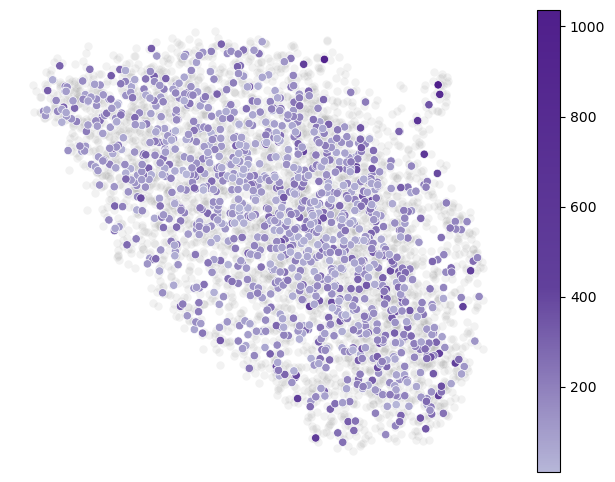

In [30]:
# show the initial pre metacells assigment
# it should cover the whole phenotipic space
f, ax = plt.subplots(figsize=(8, 6))

p1 = sns.scatterplot(x = adata.obsm['X_umap'][:,0], y = adata.obsm['X_umap'][:,1], alpha = 0.1, color = "grey", ax = ax)
p2 = sns.scatterplot(x = clust_df.umap_x, y = clust_df.umap_y, hue = clust_df.coverage,palette = custom_colormap, ax = ax)

norm = plt.Normalize(clust_df.coverage.min(), clust_df.coverage.max())
sm = plt.cm.ScalarMappable(cmap=custom_colormap, norm=norm)
sm.set_array([])

p2.get_legend().remove()
p2.figure.colorbar(sm)
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
plt.show()

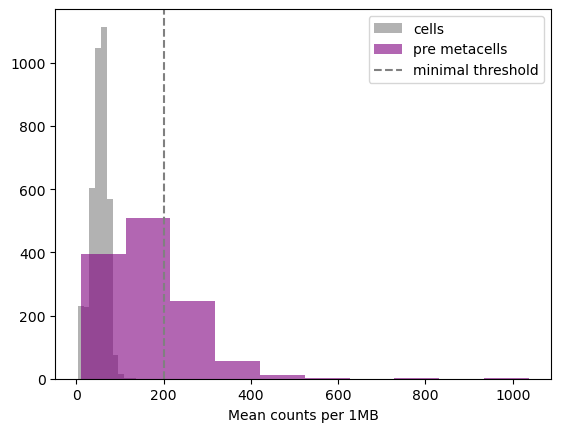

In [31]:
# Counts distribution per 1MB
plt.hist(counts_df.mean(axis =1), label = "cells", alpha = 0.6, color = "grey")
plt.hist(clust_df.coverage, alpha = 0.6, label = "pre metacells", color = "purple")

plt.axvline(200, label = "minimal threshold", ls = "--", color = "grey")
plt.legend()
plt.xlabel("Mean counts per 1MB")
plt.show()

In [33]:
# compute distance between premetacells
pcs = [x for x in clust_df.columns if x.startswith("PC")]
dist = pairwise_distances(clust_df[pcs])

## Selection of the optimal distance between two points to be merged into one metacell

Selection of the distance has large impact on the metacelling results.
To get a good intuition about different thresholds, we compute 10 quantiles of all possible distances

In [34]:
ts = np.quantile(dist[np.triu_indices(dist.shape[0], k = 1)], np.linspace(0.01,1, num = 10))


In [36]:
# This step my take up to 30 minutes to run depending on the size of the dataset
# If it takes too long, reuduce the number of quantiles in the cell above
results = []
tmp = pd.DataFrame(adata.X, index = adata.obs.index, columns = adata.var.index)
for i, d_tresh in enumerate(ts):
    print(f"Starting run {i}: th. {d_tresh:.2f}")
    new_df, cell_dict, = create_metacells.merge_cells(
        d_tresh, clust_df, "leiden_small", adata, min_coverage, max_covergae)
    num_meta = new_df.shape[0]
    size_meta = new_df.n_cells.median()
    excluded = len([cell for cell in cell_dict if cell_dict[cell] == "-1"])
    med_cov = new_df.coverage.median()
    reversed_dict = {value: [key for key in cell_dict if cell_dict[key] == value]
                     for value in set(cell_dict.values())}
    stds = [tmp.loc[reversed_dict[key]].std().mean() for key in reversed_dict]
    results.append((d_tresh, num_meta, size_meta,
                   excluded, med_cov, np.mean(stds)))
    print(f"Done with run {i}: th. {d_tresh:.2f}, # metacells {num_meta}, median size {size_meta}, {excluded} cells excluded, median coverage {med_cov:.2f}")

Starting run 0: th. 19.84
metacells to process: 838
Iteration 0
metacells to process: 155
Iteration 1
metacells to process: 151
Iteration 2
metacells to process: 149
Iteration 3
metacells to process: 149
stagnation
Iteration 4
metacells to process: 91
Iteration 5
metacells to process: 48
Iteration 6
metacells to process: 45
Iteration 7
metacells to process: 44
Iteration 8
metacells to process: 44
stagnation
Iteration 9
metacells to process: 19
Iteration 10
metacells to process: 10
Iteration 11
metacells to process: 10
stagnation
Iteration 12
metacells to process: 2
Iteration 13
metacells to process: 1
Iteration 14
metacells to process: 1
stagnation
Iteration 15
metacells to process: 0
DONE with 410 metacells in total
Done with run 0: th. 19.84, # metacells 410, median size 5.0, 1615 cells excluded, median coverage 280.15
Starting run 1: th. 25.19
metacells to process: 838
Iteration 0
metacells to process: 502
Iteration 1
metacells to process: 482
Iteration 2
metacells to process: 481
I

In [37]:
# Aggregate results from metacell analysis
res = pd.DataFrame(results, columns = ["t", "# metacells","median_meta_size","cells_excluded","median_coverage", "mean_std"])
res.cells_excluded = res.cells_excluded/adata.obs.shape[0]


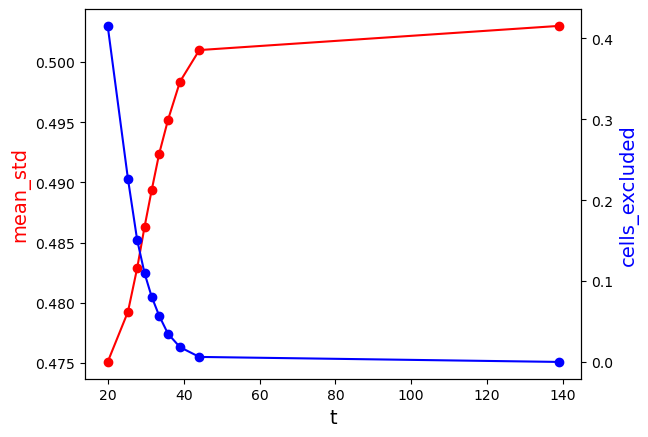

In [46]:
double_figure(res,"t","mean_std","cells_excluded")

In [47]:
# a reasonable threshold for the distance depends on the desired trade-off between the proportion of cells that will be lost
# (right y scale) and variance within metacell. In this example we assume that we don't want to lose more that 10% of
# cells and therefore we choose 4th value of t as the distance threshold
new_df,cell_dict, = create_metacells.merge_cells(ts[4],clust_df,"leiden_small",adata, min_coverage,max_covergae)

metacells to process: 838
Iteration 0


metacells to process: 657
Iteration 1
metacells to process: 629
Iteration 2
metacells to process: 627
Iteration 3
metacells to process: 627
stagnation
Iteration 4
metacells to process: 458
Iteration 5
metacells to process: 362
Iteration 6
metacells to process: 343
Iteration 7
metacells to process: 343
stagnation
Iteration 8
metacells to process: 256
Iteration 9
metacells to process: 189
Iteration 10
metacells to process: 169
Iteration 11
metacells to process: 166
Iteration 12
metacells to process: 166
stagnation
Iteration 13
metacells to process: 112
Iteration 14
metacells to process: 76
Iteration 15
metacells to process: 54
Iteration 16
metacells to process: 48
Iteration 17
metacells to process: 47
Iteration 18
metacells to process: 47
stagnation
Iteration 19
metacells to process: 23
Iteration 20
metacells to process: 10
Iteration 21
metacells to process: 5
Iteration 22
metacells to process: 5
stagnation
Iteration 23
metacells to process: 1
Iteration 24
metacells to process: 1
stagnat

## Visualization of metacelling results

/tmp/ipykernel_32020/200751220.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  p2.figure.colorbar(sm)


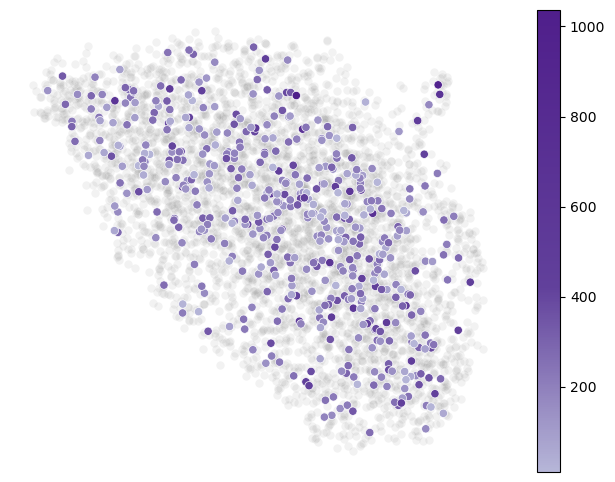

In [48]:
f, ax = plt.subplots(figsize=(8, 6))

p1 = sns.scatterplot(x = adata.obsm['X_umap'][:,0], y = adata.obsm['X_umap'][:,1], alpha = 0.1, color = "grey",
                    ax = ax)
p2 = sns.scatterplot(x = new_df.umap_x, y = new_df.umap_y, hue = new_df.coverage,palette = custom_colormap,
                    ax = ax)

norm = plt.Normalize(clust_df.coverage.min(), clust_df.coverage.max())
sm = plt.cm.ScalarMappable(cmap=custom_colormap, norm=norm)
sm.set_array([])

p2.get_legend().remove()
p2.figure.colorbar(sm)
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)


plt.show()

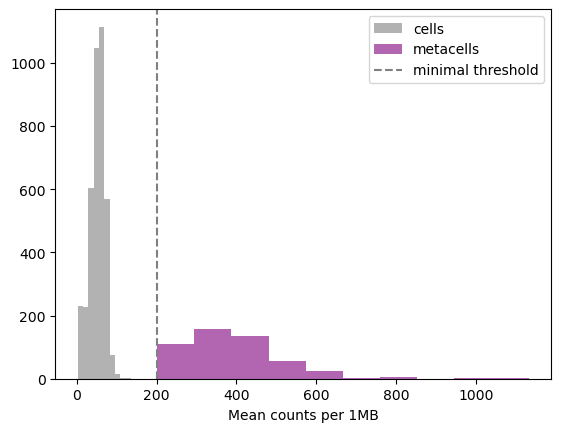

In [49]:
plt.hist(counts_df.mean(axis =1), label = "cells", alpha = 0.6, color = "grey")
plt.hist(new_df.coverage, alpha = 0.6, label = "metacells", color = "purple")

plt.axvline(200, label = "minimal threshold", ls = "--", color = "grey")
plt.legend()
plt.xlabel("Mean counts per 1MB")
plt.show()

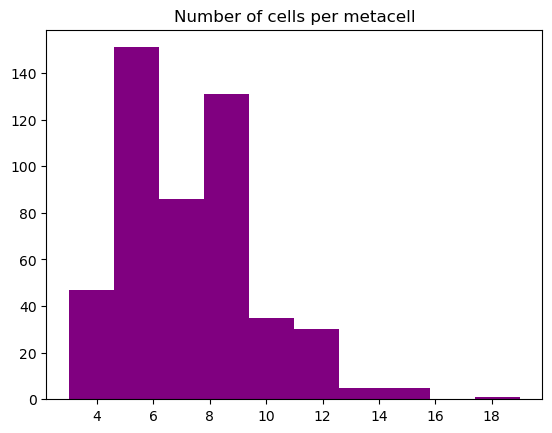

In [50]:
plt.title("Number of cells per metacell")
plt.hist(new_df.n_cells, color = "purple")
plt.show()

In [51]:
# path where to save metacells (make sure it exists)
mc_path = work_dir+'metacells/'

In [116]:
# here we save paths to the readcounts files for each metacell
# make sure that the paths are correct
# here my readcounts files are in the folder readCount_filtered_bam and have the name readcounts.100kb.cell_bc_{cell}.seg
for mc in tqdm(new_df.cl):
    cells = [x for x in cell_dict if cell_dict[x] == mc]

    with open(f'{mc_path}{mc}.txt', 'a') as the_file:
        for cell in cells:
            full_path = f'{work_dir}readCount_filtered_bam/readcounts.100kb.cell_bc_{cell}.seg'
            the_file.write(f'{full_path}\n')

100%|██████████| 470/470 [00:05<00:00, 92.79it/s] 
